In [12]:
from astropy.table import Table
import pandas as pd
import numpy as np
import scipy
import os
import tqdm
import astropy.units as u
import multiprocessing as mp

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})
rc('text', usetex=True)
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
rc('axes', facecolor='white')

import lightkurve as lk
import cesium
from cesium import time_series
# from cesium import featurize
from astropy.timeseries import LombScargle

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [5]:
def load_lc(kic, survey='kepler'):
    
    if survey == 'kepler':
        loaded = np.load(f"../lurie_lc/KIC{str(kic)}.npz")
    elif survey == 'tess':
        loaded = np.load(f"../tess_lc/TIC{str(kic)}.npz")
    lc = lk.LightCurve(time=loaded['time'], flux=loaded['flux'], flux_err=loaded['flux_err']).remove_nans()
    
    return lc


def compute_features(kic, survey='kepler'):
    
    features_to_use = ["amplitude",
                       "flux_percentile_ratio_mid20",
                       "flux_percentile_ratio_mid35",
                       "flux_percentile_ratio_mid50",
                       "flux_percentile_ratio_mid65",
                       "flux_percentile_ratio_mid80",
                       "percent_difference_flux_percentile",
                       "percent_beyond_1_std",
                       "skew",
                       "std",
                       "stetson_j",
                       "stetson_k",
                       "weighted_average",
                       "median_absolute_deviation",
                       "period_fast"
                      ]
    lc = load_lc(kic, survey=survey)
    ftable = cesium.featurize.featurize_time_series(lc.time.value, 
                                             lc.flux.value, 
                                             errors=lc.flux_err.value, 
                                             features_to_use=features_to_use)
    ftable['KIC'] = kic
    return ftable

### Compute table of training features for each target

In [ ]:
# Compute training features (skip this cell, if you already have a table of features saved)

dl_ids = [x.strip('KIC').strip('.npz') for x in os.listdir("../lurie_lc")]

samp_feat = []
for kic in tqdm.tqdm(dl_ids):
    samp_feat.append(compute_features(kic))
    
# ==========================================

catalog_param = ['KIC', 'morph', 'period', 'BP-RP', 'Gmag', 'RUWE', 'Class']

samp_feat_table = pd.concat(samp_feat).droplevel(level=1, axis=1)
ftable_full = pd.merge(samp_feat_table, comb[catalog_param], on='KIC')
ftable_full = ftable_full.dropna()
ftable_full.to_csv("training_feature_table.csv")

### Load table of training features for each target

In [7]:
ftable_full = pd.read_csv("../tables/training_feature_table.csv")

labels = list(ftable_full.keys())
labels.remove('Class')
labels.remove('KIC')
labels.remove('Unnamed: 0')
X = np.array(ftable_full[labels])

y = np.array(ftable_full[['Class']]).T[0]
y[y == 'pux'] = 'ot'
y[y == 'pu'] = 'ot'
y[y == 'ot'] = 'ot'
y[y == 'ce'] = 'ot'

# Divide sample into training set (used to train the model) 
# and test set (held out from the model, used to evaluate classifier accuracy)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

### Train random forest classifier using sklearn 

In [8]:
rfc = RandomForestClassifier(n_estimators=128, random_state=0) 
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.8429319371727748

Plot classifier feature importances

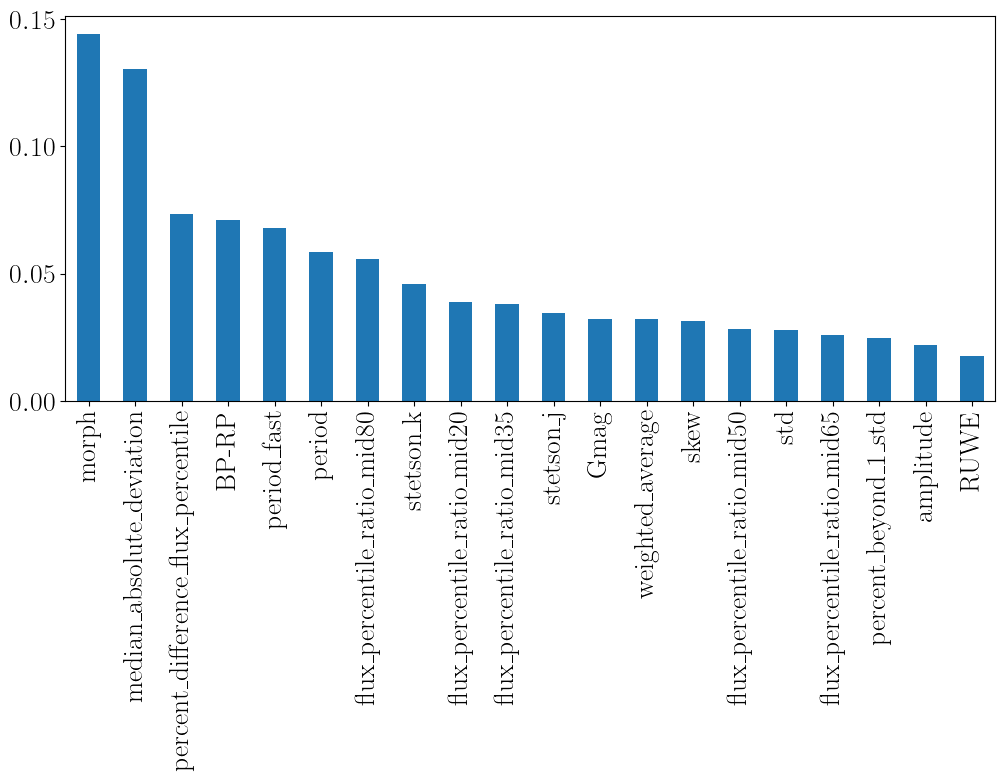

In [13]:
fig = pd.Series(rfc.feature_importances_, index=labels).sort_values(ascending=False).plot(kind='bar', figsize=[12,5], rot=90)
# fig.get_figure().savefig("ml_plots/random_forest_feature_importance.png", bbox_inches="tight")

Predict classifications of test sample (held out from training), and compute accuracies:

/home/jbirky/.conda/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


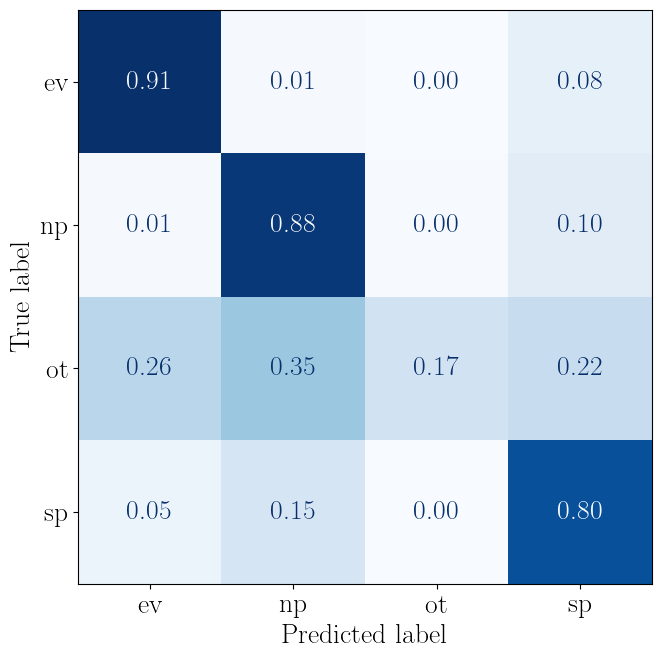

In [16]:
fig, ax = plt.subplots(figsize=(7,7))
metrics.plot_confusion_matrix(rfc, X_test, y_test, ax=ax, 
                              cmap='Blues', colorbar=False, 
                              normalize='true', values_format=".2f")
ax.set_xlabel("Predicted label", fontsize=20)
ax.set_ylabel("True label", fontsize=20)
# ax.set_xtick(fontsize=20)
# fig.savefig("ml_plots/random_forest_confusion_matrix.png")
plt.tight_layout()